Saving mental_health_workplace_survey.csv to mental_health_workplace_survey (11).csv
Total Rows: 3000
Total Coloumns: 25
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   EmployeeID              3000 non-null   int64  
 1   Age                     3000 non-null   int64  
 2   Gender                  3000 non-null   object 
 3   Country                 3000 non-null   object 
 4   JobRole                 3000 non-null   object 
 5   Department              3000 non-null   object 
 6   YearsAtCompany          3000 non-null   int64  
 7   WorkHoursPerWeek        3000 non-null   int64  
 8   RemoteWork              3000 non-null   object 
 9   BurnoutLevel            3000 non-null   float64
 10  JobSatisfaction         3000 non-null   float64
 11  StressLevel             3000 non-null   float64
 12  ProductivityScore       3

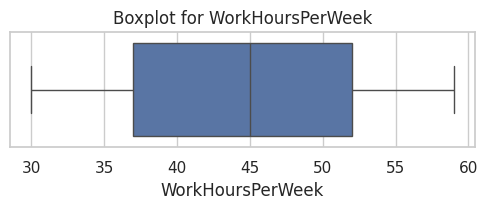

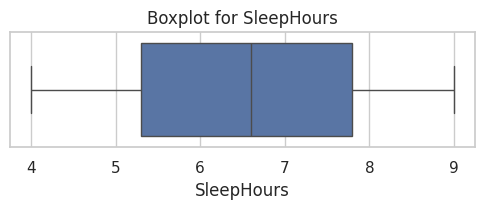

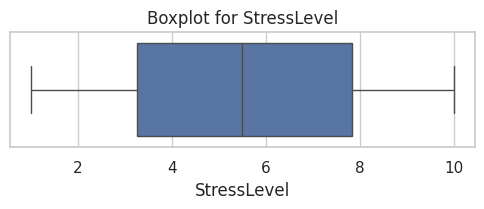

0 outliers removed from 'WorkHoursPerWeek'
0 outliers removed from 'SleepHours'
0 outliers removed from 'StressLevel'


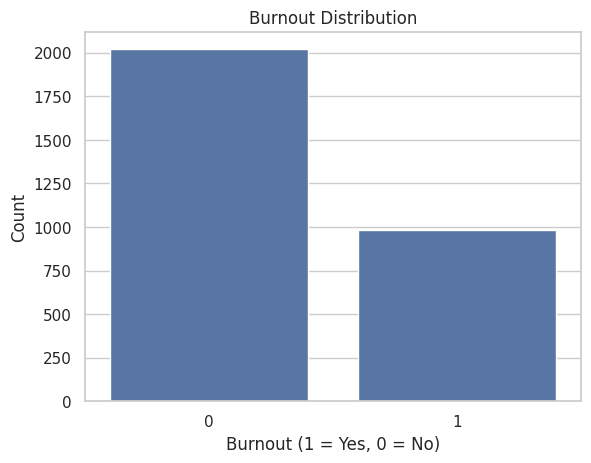

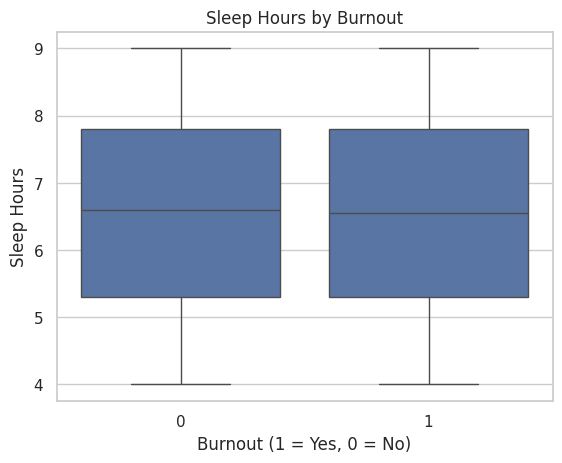

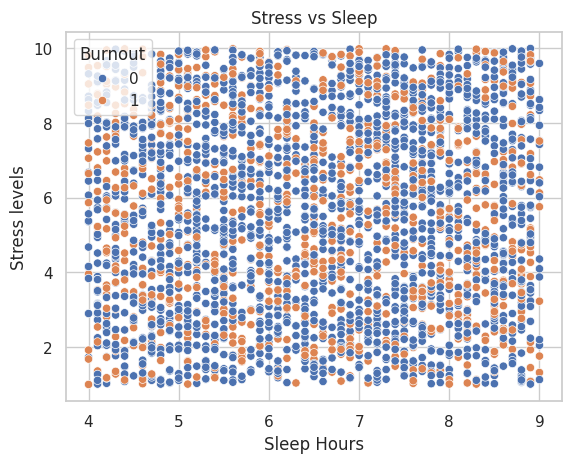

Cleaned dataset saved successfully.
Evaluation Results:
                        MSE        R²
Linear Regression  0.148626  0.977557
Ridge Regression   0.148666  0.977551
Lasso Regression   1.776867  0.731689
Best Performing Model: Linear Regression
Reason: Linear Regression achieved the highest R², explaining most variance in StressLevel with lowest error.


In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, mutual_info_regression

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)

from google.colab import files
uploaded = files.upload()
df = pd.read_csv('mental_health_workplace_survey.csv')
df.head()

#gives the no of the rows and coloumns using the index of the axis
print("Total Rows:",df.shape[0])
print("Total Coloumns:",df.shape[1])
#gives all the non-null data
df.info()
df.describe

#checks whether a particular data is missing in each coloumn
df.isnull().sum()

numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    df[col].fillna(df[col].median(), inplace=True)

categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

#outliners are fixed using boxplot and interquartile range
features = ['WorkHoursPerWeek', 'SleepHours', 'StressLevel']
for col in features:
    plt.figure(figsize=(6, 1.5))
    sns.boxplot(data=df, x=col)
    plt.title(f"Boxplot for {col}")
    plt.show()
def remove_outliners_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    original_size = df.shape[0]
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    removed = original_size - df.shape[0]
    print(f"{removed} outliers removed from '{col}'")
    return df
for col in ['WorkHoursPerWeek', 'SleepHours', 'StressLevel']:
    df = remove_outliners_iqr(df,col)

#Burnout count Distribution
sns.countplot(x='BurnoutRisk', data=df)
plt.title("Burnout Distribution")
plt.xlabel("Burnout (1 = Yes, 0 = No)")
plt.ylabel("Count")
plt.show()

#Burnout Risk caused by SleepHours
sns.boxplot(x='BurnoutRisk', y='SleepHours', data=df)
plt.title("Sleep Hours by Burnout")
plt.xlabel("Burnout (1 = Yes, 0 = No)")
plt.ylabel("Sleep Hours")
plt.show()

#ScatterPlot of Stress vs Sleep
sns.scatterplot(x = 'SleepHours', y = 'StressLevel', hue = 'BurnoutRisk',data = df)
plt.title("Stress vs Sleep")
plt.xlabel("Sleep Hours")
plt.ylabel("Stress levels")
plt.legend(title = "Burnout")
plt.show()


df.to_csv("cleaned_burnout_dataset.csv", index=False)
print("Cleaned dataset saved successfully.")


y = df['StressLevel']


categorical_cols = ['Gender', 'Country', 'JobRole', 'Department', 'RemoteWork',
                   'HasMentalHealthSupport', 'HasTherapyAccess', 'SalaryRange']

encoder = OneHotEncoder(drop='first',sparse_output=False)
encoded_array = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_cols))

df_encoded = df.drop(categorical_cols, axis=1).reset_index(drop=True)
encoded_df.reset_index(drop=True, inplace=True)
df_encoded = pd.concat([df_encoded, encoded_df], axis=1)

df_encoded.head()

df_encoded['Stress_WorkHours'] = df_encoded['StressLevel'] * df_encoded['WorkHoursPerWeek']
df_encoded['Sleep_vs_Stress'] = df_encoded['SleepHours'] * (df_encoded['StressLevel'] + 1)



numerical_cols = ['Age', 'YearsAtCompany', 'WorkHoursPerWeek', 'BurnoutLevel',
                  'ProductivityScore', 'SleepHours', 'PhysicalActivityHrs',
                  'CommuteTime', 'MentalHealthDaysOff', 'TeamSize',
                  'JobSatisfaction', 'ManagerSupportScore', 'WorkLifeBalanceScore',
                  'CareerGrowthScore', 'Stress_WorkHours', 'Sleep_vs_Stress']

scaler = StandardScaler()
scaled_array = scaler.fit_transform(df_encoded[numerical_cols])
scaled_df = pd.DataFrame(scaled_array, columns=numerical_cols)

# Drop original numerical columns and concatenate scaled columns
df_encoded.drop(numerical_cols, axis=1, inplace=True)
scaled_df.reset_index(drop=True, inplace=True)
df_encoded = pd.concat([df_encoded.reset_index(drop=True), scaled_df], axis=1)

scaled_df[numeric_cols].head()

# Correlation-based selection
corr_matrix = df_encoded.corr()
target_corr = corr_matrix['StressLevel'].sort_values(ascending=False)
selected_features_corr = target_corr[(abs(target_corr) > 0.1)].index.tolist()
selected_features_corr.remove('StressLevel')

# Mutual Information
X_all = df_encoded.drop('StressLevel', axis=1)
selector = SelectKBest(score_func=mutual_info_regression, k='all')
selector.fit(X_all, y)
mutual_info_features = X_all.columns[selector.get_support()].tolist()

# Force interaction features into selection
forced_features = ['Stress_WorkHours', 'Sleep_vs_Stress']

# Final selected features
selected_features = list(set(selected_features_corr + mutual_info_features + forced_features))

# Feature matrix
X = df_encoded[selected_features]
y = df_encoded['StressLevel']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R²': r2}


print("Evaluation Results:")
results_df = pd.DataFrame(results).T
print(results_df)

best_model = results_df['R²'].idxmax()
print(f"Best Performing Model: {best_model}")
print(f"Reason: {best_model} achieved the highest R², explaining most variance in StressLevel with lowest error.")
